# FIFA22 Players Dataset

In [2]:
# pip install plotly.express

In [3]:
import os
import warnings

import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px





### The project 

The World Cup is the most viewed sporting event in the world. In this project you'll leverage various sources of team and player data to construct models to predict the outcome of matches in the FIFA World Cup 2022 and evaluate those models against a baseline of predictions made using only the FIFA Ranking measure of team strength.

In [4]:
# print(os.getcwd())
path = './data/'
df = pd.read_csv(path + 'players/players_22.csv')
country_code = pd.read_csv(path + 'iso3digit_country_codes.csv')
fifa_country_code = pd.read_csv(path + 'fifa_country_codes.csv')
df_ = df.copy()


/var/folders/15/xmw2zw8j6v99f_2tv3_vxtqw0000gn/T/ipykernel_2351/1576206233.py:3: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + 'players/players_22.csv')


In [6]:
df_.shape

(19239, 110)

In [5]:
fifa_country_code = fifa_country_code[fifa_country_code.columns.drop("Unnamed: 0")]

In [6]:
fifa_country_code.rename(columns={"Country/Independent State": "country"}, inplace=True)

In [7]:
# Custom summary for database columns
columns = {}
for col in df.columns:
       temp = {}
       temp["count_non_null"] = df[col].notna().sum()
       temp["type"] = df[col].dtype
       if pd.api.types.is_numeric_dtype(df[col]):
              colmean = np.nanmean(df[col])
              colstd = np.nanstd(df[col])
       else:
             colmean = None
             colstd = None
       temp["mean"] = colmean
       temp["std"] = colstd
       temp["head"] = list(df[col].head())
       temp["sep"] = "-"*70
       # print(temp)
       columns[col] = temp


In [8]:
# Saving columns summary to txt
with open("players_features.txt", "w") as f:
    f.write(str(columns))

In [9]:
# Add country 3 alpha digit code
df = df_.merge(fifa_country_code, left_on="nationality_name", right_on="country", how="inner").drop(["country", "IOC"], axis=1)
df.rename(columns={"FIFA": "Code Value"}, inplace=True)

In [10]:
df

sofifa_id                                         player_url  \
0         158023  https://sofifa.com/player/158023/lionel-messi/...   
1         153079  https://sofifa.com/player/153079/sergio-aguero...   
2         183898  https://sofifa.com/player/183898/angel-di-mari...   
3         211110  https://sofifa.com/player/211110/paulo-dybala/...   
4         143076  https://sofifa.com/player/143076/alejandro-gom...   
...          ...                                                ...   
18327     259857  https://sofifa.com/player/259857/ayom-majok/22...   
18328     263543   https://sofifa.com/player/263543/ajak-deu/220002   
18329     240805  https://sofifa.com/player/240805/wai-tsun-dai/...   
18330     257494  https://sofifa.com/player/257494/chun-lok-tan/...   
18331     264469  https://sofifa.com/player/264469/witan-sulaema...   

         short_name                          long_name player_positions  \
0          L. Messi     Lionel Andrés Messi Cuccittini       RW, ST, CF   
1         S. Agüero  Sergio Leonel Agüero del Castillo               ST   
2       Á. Di María    Ángel Fabián Di María Hernández           RW, LW   
3         P. Dybala        Paulo Bruno Exequiel Dybala          CF, CAM   
4          A. Gómez              Alejandro Darío Gómez      CAM, CF, CM   
...             ...                                ...              ...   
18327      A. Majok                         Ayom Majok           ST, RW   
18328        A. Deu                           Ajak Deu               CB   
18329  Dai Wai-Tsun                       Wai-Tsun Dai               CM   
18330  Tan Chun Lok                       Chun Lok Tan               CM   
18331   W. Sulaeman                     Witan Sulaeman               RM   

       overall  potential   value_eur  wage_eur  age  ...    cb   rcb    rb  \
0           93         93  78000000.0  320000.0   34  ...  50+3  50+3  61+3   
1           87         87  51000000.0  260000.0   33  ...  50+3  50+3  54+3   
2           87         87  49500000.0  160000.0   33  ...  58+3  58+3  67+3   
3           87         88  93000000.0  160000.0   27  ...  52+3  52+3  62+3   
4           85         85  33500000.0   51000.0   33  ...  49+3  49+3  61+3   
...        ...        ...         ...       ...  ...  ...   ...   ...   ...   
18327       50         67    120000.0     500.0   20  ...  29+2  29+2  35+2   
18328       49         65    120000.0     500.0   20  ...  49+2  49+2  46+2   
18329       57         67    375000.0    1000.0   21  ...  52+2  52+2  56+2   
18330       49         51     60000.0    2000.0   25  ...  46+2  46+2  48+2   
18331       51         62    130000.0     800.0   19  ...  34+2  34+2  41+2   

         gk                                    player_face_url  \
0      19+3  https://cdn.sofifa.net/players/158/023/22_120.png   
1      21+3  https://cdn.sofifa.net/players/153/079/22_120.png   
2      18+3  https://cdn.sofifa.net/players/183/898/22_120.png   
3      14+3  https://cdn.sofifa.net/players/211/110/22_120.png   
4      17+3  https://cdn.sofifa.net/players/143/076/22_120.png   
...     ...                                                ...   
18327  13+2  https://cdn.sofifa.net/players/259/857/22_120.png   
18328  13+2  https://cdn.sofifa.net/players/263/543/22_120.png   
18329  12+2  https://cdn.sofifa.net/players/240/805/22_120.png   
18330  16+2  https://cdn.sofifa.net/players/257/494/22_120.png   
18331  15+2  https://cdn.sofifa.net/players/264/469/22_120.png   

                                    club_logo_url  \
0          https://cdn.sofifa.net/teams/73/60.png   
1         https://cdn.sofifa.net/teams/241/60.png   
2          https://cdn.sofifa.net/teams/73/60.png   
3          https://cdn.sofifa.net/teams/45/60.png   
4         https://cdn.sofifa.net/teams/481/60.png   
...                                           ...   
18327  https://cdn.sofifa.net/teams/114023/60.png   
18328  https://cdn.sofifa.net/teams/114023/60.png   
18329  https://cdn.sofifa.net/team

In [11]:
# FOR FIFA 3D CODES
# Check if all countries have a 3 letter code by doing a left join and retrieving unmatched cases
check = df_.merge(fifa_country_code, left_on="nationality_name", how="left", right_on="country")
missing_country = check[check.country.isna()]["nationality_name"].unique()
missing_country
# Manually assign correct country code
missing_dict = {}

# standard_country = [ # from iso 3 digit merge
#     "GBR", "KOR", "GBR", "SRB", "CIV", "GBR",
#     "RUS", "CZE", "GBR", "COD", "CHN", "MKD",
#     "IRN", "GBR", "CPV", "XXK", "LBY", "SYR", 
#     "GNB", "CUW", "TZA", "MDA", "KNA", "KAZ", 
#     "TWN", "KOR", "PSE"
#     ]

standard_country = [ # from fifa merge
    "NED", "CIV", "BIH", "USA", "COD", "MKD",
    "SUR", "TRI", "GNB", "SKN", "COM", "ATG",
    "FRO", "LCA", "VIE",

    ]

for i, country in enumerate(missing_country):
    missing_dict[country] = standard_country[i]

# Format missing country codes
missing_df = pd.DataFrame(pd.Series(missing_dict), columns=["FIFA"])
missing_df.index = missing_df.index.set_names("country")
missing_df = missing_df.reset_index()

# Append to original country code database
country_code_ = pd.concat([fifa_country_code, missing_df], axis=0, ignore_index=True)

country_code_



country FIFA  IOC
0                Algeria  ALG  ALG
1                 Angola  ANG  ANG
2                  Benin  BEN  BEN
3               Botswana  BOT  BOT
4           Burkina Faso  BFA  BUR
..                   ...  ...  ...
264              Comoros  COM  NaN
265  Antigua and Barbuda  ATG  NaN
266        Faroe Islands  FRO  NaN
267          Saint Lucia  LCA  NaN
268              Vietnam  VIE  NaN

[269 rows x 3 columns]

In [12]:
# Final database with FIFA 3 digit country code
df = df_.merge(country_code_, left_on="nationality_name", right_on="country", how="inner").drop(["country", "IOC"], axis=1)
df = df.rename(columns={"FIFA": "country_3d"})

In [13]:
# FOR ISO-3D
# Check if all countries have a 3 letter code by doing a left join and retrieving unmatched cases
check = df_.merge(country_code, left_on="nationality_name", how="left", right_on="Definition")
missing_country = check[check.Definition.isna()]["nationality_name"].unique()
missing_country
# Manually assign correct country code
missing_dict = {}

standard_country = [ # from iso 3 digit merge
    "GBR", "KOR", "GBR", "SRB", "CIV", "GBR",
    "RUS", "CZE", "GBR", "COD", "CHN", "MKD",
    "IRN", "GBR", "CPV", "XXK", "LBY", "SYR", 
    "GNB", "CUW", "TZA", "MDA", "KNA", "KAZ", 
    "TWN", "KOR", "PSE"
    ]

# standard_country = [ # from fifa merge
#     "NED", "CIV", "BIH", "USA", "COD", "MKD",
#     "SUR", "TRI", "GNB", "SKN", "COM", "ATG",
#     "FRO", "LCA", "VIE",

#     ]

for i, country in enumerate(missing_country):
    missing_dict[country] = standard_country[i]

# Format missing country codes
missing_df = pd.DataFrame(pd.Series(missing_dict), columns=["Code Value"])
missing_df.index = missing_df.index.set_names("Definition")
missing_df = missing_df.reset_index()

# Append to original country code database
country_code_ = pd.concat([country_code, missing_df], axis=0, ignore_index=True)

country_code_

Code Value             Definition
0          AFG            Afghanistan
1          ALA          Aland Islands
2          ALB                Albania
3          DZA                Algeria
4          ASM         American Samoa
..         ...                    ...
273        KNA  Saint Kitts and Nevis
274        KAZ             Kazakhstan
275        TWN         Chinese Taipei
276        KOR              Korea DPR
277        PSE              Palestine

[278 rows x 2 columns]

In [14]:
# Final database with ISO 3 digit country code (needed for map plot)
df = df.merge(country_code_, left_on="nationality_name", right_on="Definition", how="inner").drop(["Definition"], axis=1)
df = df.rename(columns={"Code Value": "iso_3d"})

In [15]:
print("Top 20 countries by number of players in FIFA22")
df[["long_name", "country_3d", "nationality_name"]].groupby(["country_3d", "nationality_name"])\
    .count()\
    .sort_values(by="long_name", ascending=False)\
    .reset_index()\
    .iloc[:20,:]

Top 20 countries by number of players in FIFA22


country_3d     nationality_name  long_name
0         ENG              England       1719
1         GER              Germany       1214
2         ESP                Spain       1086
3         FRA               France        980
4         ARG            Argentina        960
5         BRA               Brazil        897
6         JPN                Japan        546
7         NED          Netherlands        439
8         USA        United States        413
9         POL               Poland        403
10        CHN             China PR        385
11        SWE               Sweden        385
12        NOR               Norway        379
13        IRL  Republic of Ireland        374
14        POR             Portugal        373
15        KSA         Saudi Arabia        355
16        MEX               Mexico        352
17        ROU              Romania        338
18        ITA                Italy        338
19        KOR       Korea Republic        325

In [16]:
print(f"The database has {df.shape[0]} rows and {df.shape[1]} columns")

The database has 19509 rows and 112 columns


In [17]:
# Datatype feature partition, including drop of irrelevant columns for overall rating
col_drop=['sofifa_id','player_url', 'club_team_id','league_name'
,'league_level','club_jersey_number','club_loaned_from','club_joined'
,'club_contract_valid_until','nationality_id', 'nation_team_id','nation_jersey_number'
,'real_face','player_tags','player_traits','player_face_url'
,'club_logo_url','club_flag_url','nation_logo_url','nation_flag_url'
,'ls','st','rs','lw'
,'lf','cf','rf','rw'
,'lam','cam','ram','lm'
,'lcm','cm','rcm','rm'
,'lwb','ldm','cdm','rdm'
,'rwb','lb','lcb','cb'
,'rcb','rb','gk'
,]

col_numerical=['overall','potential','value_eur','wage_eur'
,'age','height_cm','weight_kg','release_clause_eur'
,'pace','shooting','passing','dribbling'
,'defending','physic'
,'attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing'
,'attacking_volleys'
,'skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing'
,'skill_ball_control'
,'movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions'
,'movement_balance'
,'power_shot_power','power_jumping','power_stamina','power_strength'
,'power_long_shots'
,'mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision'
,'mentality_penalties','mentality_composure'
,'defending_marking_awareness','defending_standing_tackle','defending_sliding_tackle'
,'goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning'
,'goalkeeping_reflexes','goalkeeping_speed'
,]

col_categorical=['short_name','long_name','player_positions','dob'
,'club_name', 'club_position','nationality_name','country_3d'
, "iso_3d",'nation_position','preferred_foot','weak_foot'
,'skill_moves','international_reputation','work_rate','body_type'
,]

In [18]:
# Check that all columns have been assigned (total len == 111)
print(len(col_drop)+len(col_numerical)+len(col_categorical) == df.shape[1])

True


In [19]:
# Drop columns that are definetly irrelevant for overall performance
df = df.drop(col_drop, axis=1)
df_num = df[col_numerical]
df_cat = df[col_categorical]

In [20]:
# Identify null values within numerical features
print("Null value counts for numerical variables")
for col in col_numerical:
    if df[col].isnull().sum() != 0:
        print(col, df[col].isnull().sum())

# goalkeeping_speed
df[df["goalkeeping_speed"].notnull()]

Null value counts for numerical variables
value_eur 78
wage_eur 65
release_clause_eur 1183
pace 2164
shooting 2164
passing 2164
dribbling 2164
defending 2164
physic 2164
goalkeeping_speed 17345


short_name                      long_name player_positions  \
6           E. Martínez       Damián Emiliano Martínez               GK   
17         A. Marchesín     Agustín Federico Marchesín               GK   
19             J. Musso             Juan Agustín Musso               GK   
25           E. Andrada    Esteban Maximiliano Andrada               GK   
26            F. Armani                  Franco Armani               GK   
...                 ...                            ...              ...   
19425         A. Shaikh                    Arsh Shaikh               GK   
19428             R. By                     Revanth By               GK   
19463      P. Šteinbors               Pāvels Šteinbors               GK   
19479  K. McKenzie-Lyle  Kai John Oliver McKenzie-Lyle               GK   
19489      Đăng Văn Lâm                   Văn Lâm Đặng               GK   

       overall  potential   value_eur  wage_eur  age         dob  height_cm  \
6           84         85  33500000.0   81000.0   28  1992-09-02        195   
17          81         81   8500000.0   14000.0   33  1988-03-16        188   
19          81         83  23500000.0   44000.0   27  1994-05-06        191   
25          80         81  16000000.0   43000.0   30  1991-01-26        194   
26          80         80   3600000.0   17000.0   34  1986-10-16        189   
...        ...        ...         ...       ...  ...         ...        ...   
19425       47         67    110000.0     500.0   18  2002-07-09        186   
19428       47         55     90000.0     500.0   22  1998-11-17        181   
19463       65         65     80000.0    1000.0   35  1985-09-21        192   
19479       51         60    110000.0     900.0   23  1997-11-30        201   
19489       64         66    525000.0    2000.0   27  1993-08-13        188   

       ...  defending_standing_tackle defending_sliding_tackle  \
6      ...                         20                       20   
17     ...                         15                       15   
19     ...                         14                       16   
25     ...                         20                       14   
26     ...                         13                       19   
...    ...                        ...                      ...   
19425  ...                         14                       13   
19428  ...                         13                       13   
19463  ...                         18                       16   
19479  ...                          9                        8   
19489  ...                         10                       10   

      goalkeeping_diving goalkeeping_handling goalkeeping_kicking  \
6                     85                   83                  82   
17                    82                   77                  76   
19                    82                   78                  73   
25                    76                   79                  82   
26                    78                   76                  67   
...                  ...                  ...                 ...   
19425                 49                   41                  39   
19428                 49                   46                  43   
19463                 66                   62                  64   
19479                 52                   50                  49   
19489                 65                   61                  58   

      goalkeeping_positioning  goalkeeping_reflexes  goalkeeping_speed  \
6                          83                    85               58.0   
17                         80                    83               54.0   
19                         82                    86               44.0   
25                         81                    83               44.0   
26                         79                    85               43.0   
...                       ...                   ...                ...   
19425                  

In [21]:
# Identify null values within numerical features
print("Null value counts for categorical variables")
for col in col_categorical:
    if df[col].isnull().sum() != 0:
        print(col, df[col].isnull().sum())

# Replace nation_position using first listed player_position, given number of null values
temp = df.player_positions.str.split(",").apply(lambda x: x[0])
df["nation_position"] = temp
# Impute club_position using first listed player_position
df["club_position"].fillna(df["nation_position"], inplace=True)

Null value counts for categorical variables
club_name 65
club_position 65
nation_position 18727


In [22]:
# Custom imputer to be able to compute cluster means
class WithinGroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_var):
        self.group_var = group_var
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # the copy leaves the original dataframe intact
        X_ = X.copy()
        for col in X_.columns:
            if X_[col].dtypes == 'float64' or X_[col].dtypes == 'int64':
                X_.loc[(X[col].isna()) & X_[self.group_var].notna(), col] = X_[self.group_var].map(X_.groupby(self.group_var)[col].mean())
                X_[col] = X_[col].fillna(X_[col].mean())
            else:
                X_.loc[(X[col].isna()) & X_[self.group_var].notna(), col] = X_[self.group_var].map(X_.groupby(self.group_var)[col].agg(pd.Series.mode))
                X_[col] = X_[col].fillna(X_[col].agg(pd.Series.mode))
        return X_

# Reference
# https://stackoverflow.com/questions/67515224/simpleimputer-with-groupby

In [23]:
# Impute goalkeeping_speed with 0 (average wouldn't work because only GKs have a value for this feature)
df["goalkeeping_speed"].fillna(0, inplace=True)

col_numerical_ = [col for col in col_numerical if col!="goalkeeping_speed"]

# Impute null values using mean for numerical and mode for categorical,
# clustering by main player position (was previously imputed through nation_position)
imp = WithinGroupImputer(group_var="nation_position")
imp.fit(df)
temp = imp.transform(df)
# Update df_num, df_cat
df_num = temp[col_numerical]
df_cat = temp[col_categorical]

In [24]:
df = pd.concat([df_cat, df_num], axis=1)

In [25]:
# 90th percentile of overall performance, per country
overall_q90 = df[["country_3d", "overall"]].groupby("country_3d").quantile(.90).reset_index()
overall_q90 = overall_q90.rename(columns={"overall":"overall_q90"})
overall_q90[overall_q90.country_3d=="ENG"]

country_3d  overall_q90
47        ENG         73.0

In [26]:
df = df.merge(overall_q90, on="country_3d", how="left")


In [27]:
# Keep only players that belong to the country's 90th percentile of overall performance
df["top_player"] = df["overall"] > df["overall_q90"]
df = df[df.top_player ==True]

In [28]:
# Count players per country
total_players = df[["country_3d", "overall"]].groupby("country_3d").count().reset_index()
total_players = total_players.rename(columns={"overall":"total_players"})
total_players.sort_values(by="total_players", ascending=False).head()

country_3d  total_players
40        ENG            155
49        GER            112
42        ESP            103
44        FRA             85
16        BRA             85

In [29]:
df = df.merge(total_players, on="country_3d", how="left")


In [30]:
df[df.country_3d=="ENG"].head(20)

short_name               long_name player_positions         dob  \
469              H. Kane              Harry Kane               ST  1993-07-28   
470          R. Sterling         Raheem Sterling           LW, RW  1994-12-08   
471  T. Alexander-Arnold  Trent Alexander-Arnold               RB  1998-10-07   
472            J. Sancho            Jadon Sancho       RM, CF, LM  2000-03-25   
473             J. Vardy             Jamie Vardy               ST  1987-01-11   
474            K. Walker             Kyle Walker               RB  1990-05-28   
475          M. Rashford         Marcus Rashford           LM, ST  1997-10-31   
476         J. Henderson        Jordan Henderson          CDM, CM  1990-06-17   
477          K. Trippier         Kieran Trippier      RB, RWB, RM  1990-09-19   
478           H. Maguire           Harry Maguire               CB  1993-03-05   
479              L. Shaw               Luke Shaw               LB  1995-07-12   
480          J. Grealish           Jack Grealish      LW, LM, CAM  1995-09-10   
481             P. Foden            Philip Foden      CAM, LW, CM  2000-05-28   
482            J. Stones             John Stones               CB  1994-05-28   
483              N. Pope               Nick Pope               GK  1992-04-19   
484          J. Pickford         Jordan Pickford               GK  1994-03-07   
485       A. Wan-Bissaka       Aaron Wan-Bissaka               RB  1997-11-26   
486             M. Mount             Mason Mount      CAM, CM, RW  1999-01-10   
487          J. Maddison          James Maddison          CAM, CM  1996-11-23   
488             J. Gomez               Joe Gomez               CB  1997-05-23   

              club_name club_position nationality_name country_3d iso_3d  \
469   Tottenham Hotspur            ST          England        ENG    GBR   
470     Manchester City           SUB          England        ENG    GBR   
471           Liverpool            RB          England        ENG    GBR   
472   Manchester United            LM          England        ENG    GBR   
473      Leicester City            ST          England        ENG    GBR   
474     Manchester City            RB          England        ENG    GBR   
475   Manchester United           SUB          England        ENG    GBR   
476           Liverpool           RCM          England        ENG    GBR   
477  Atlético de Madrid           SUB          England        ENG    GBR   
478   Manchester United           LCB          England        ENG    GBR   
479   Manchester United            LB          England        ENG    GBR   
480     Manchester City            LW          England        ENG    GBR   
481     Manchester City           SUB          England        ENG    GBR   
482     Manchester City           SUB          England        ENG    GBR   
483             Burnley            GK          England        ENG    GBR   
484             Everton            GK          England        ENG    GBR   
485   Manchester United            RB          England        ENG    GBR   
486             Chelsea            RW          England        ENG    GBR   
487      Leicester City           CAM          England        ENG    GBR   
488           Liverpool           SUB          England        ENG    GBR   

    nation_position  ... defending_sliding_tackle  goalkeeping_diving  \
469              ST  ...                       38                   8   
470              LW  ...                       47                  15   
471              RB  ...                       79                  14   
472              RM  ...                       32                   7   
473              ST  ...                       54                  15   
474              RB  ...                       83                  12   
475              LM  ...                       33                  11   
476             CDM  ...                       76                   7   
477              RB  ...                       80         

In [31]:
temp = df[df.total_players>=5][["nationality_name","iso_3d","overall"]].groupby(["nationality_name","iso_3d"]).mean().sort_values(by="overall", ascending=False).reset_index()
fig = px.choropleth(temp, locations="iso_3d",
                    color="overall", # lifeExp is a column of gapminder
                    hover_name="nationality_name", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Viridis,
                    labels={
                     "overall": "Avg Rating",
                    },
                    title="FIFA 22 Players' Average Overall Rating <br>*for countries with >=10 top players")
fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=50),
)
fig.update_geos(lataxis_range=[-59, 90])
fig.show()

In [32]:
df[col_categorical].head()

short_name                          long_name player_positions  \
0     L. Messi     Lionel Andrés Messi Cuccittini       RW, ST, CF   
1    S. Agüero  Sergio Leonel Agüero del Castillo               ST   
2  Á. Di María    Ángel Fabián Di María Hernández           RW, LW   
3    P. Dybala        Paulo Bruno Exequiel Dybala          CF, CAM   
4     A. Gómez              Alejandro Darío Gómez      CAM, CF, CM   

          dob            club_name club_position nationality_name country_3d  \
0  1987-06-24  Paris Saint-Germain            RW        Argentina        ARG   
1  1988-06-02         FC Barcelona            ST        Argentina        ARG   
2  1988-02-14  Paris Saint-Germain           SUB        Argentina        ARG   
3  1993-11-15             Juventus           CAM        Argentina        ARG   
4  1988-02-15           Sevilla FC           LCM        Argentina        ARG   

  iso_3d nation_position preferred_foot  weak_foot  skill_moves  \
0    ARG              RW           Left          4            4   
1    ARG              ST          Right          4            4   
2    ARG              RW           Left          2            5   
3    ARG              CF           Left          3            4   
4    ARG             CAM          Right          4            4   

   international_reputation      work_rate      body_type  
0                         5     Medium/Low         Unique  
1                         4    High/Medium         Unique  
2                         4    High/Medium         Unique  
3                         3  Medium/Medium         Unique  
4                         3    High/Medium  Normal (170-)

In [111]:
# Column pre prep for regression
col_exclude = ["overall", "short_name","long_name","player_positions"
    ,"dob","club_name","club_position","nationality_name"
    ,"weak_foot","skill_moves", "international_reputation","work_rate"
    ,"nation_position","potential","release_clause_eur","iso_3d",
    "country_3d"
    ]
col_nominal_ = [col for col in col_categorical if col not in col_exclude]
col_ordinal_ = ["work_rate"]
col_numerical_ = [col for col in col_numerical if col not in col_exclude]

ohe = OneHotEncoder(sparse=False) # no need to drop="first" because we will be running a regularized regression.
oe = OrdinalEncoder(categories=
    [['Low/Low',
    'Low/Medium',
    'Low/High',
    'Medium/Low',
    'Medium/Medium',
    'Medium/High',
    'High/Low',
    'High/Medium',
    'High/High',
    ]])
ss = StandardScaler()

col_transform = make_column_transformer(
    (ohe, col_nominal_)
    ,(oe, col_ordinal_)
    ,(ss, col_numerical_))

X = col_transform.fit_transform(df[col_nominal_ + col_ordinal_ + col_numerical_])

# References
# https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79


In [112]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

X_cols = get_feature_names(col_transform)

# References
# https://johaupt.github.io/blog/columnTransformer_feature_names.html

/Users/idiazj/micromamba/envs/cs109a/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/var/folders/15/xmw2zw8j6v99f_2tv3_vxtqw0000gn/T/ipykernel_2985/594517491.py:30: UserWarning:

Transformer ordinalencoder (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available

/var/folders/15/xmw2zw8j6v99f_2tv3_vxtqw0000gn/T/ipykernel_2985/594517491.py:30: UserWarning:

Transformer standardscaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available



In [113]:
X = pd.DataFrame(X, columns=X_cols)

In [114]:
# Train test split
y = df['overall']
X_train, X_test, y_train, y_test  = train_test_split(X, y
    ,test_size=0.1
    ,random_state=42)

In [115]:
# Scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

max_iter=100000
alphas = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
lcv = LassoCV(cv=5, alphas=alphas, max_iter=max_iter, fit_intercept=True)
lcv.fit(X_train_std, y_train)
y_hat_train = lcv.predict(X_train_std)
y_hat_test = lcv.predict(X_test_std)

In [116]:
X_train.columns

Index(['onehotencoder__x0_Left', 'onehotencoder__x0_Right',
       'onehotencoder__x1_Lean (170-)', 'onehotencoder__x1_Lean (170-185)',
       'onehotencoder__x1_Lean (185+)', 'onehotencoder__x1_Normal (170-)',
       'onehotencoder__x1_Normal (170-185)', 'onehotencoder__x1_Normal (185+)',
       'onehotencoder__x1_Stocky (170-)', 'onehotencoder__x1_Stocky (170-185)',
       'onehotencoder__x1_Stocky (185+)', 'onehotencoder__x1_Unique',
       'ordinalencoder__work_rate', 'standardscaler__value_eur',
       'standardscaler__wage_eur', 'standardscaler__age',
       'standardscaler__height_cm', 'standardscaler__weight_kg',
       'standardscaler__pace', 'standardscaler__shooting',
       'standardscaler__passing', 'standardscaler__dribbling',
       'standardscaler__defending', 'standardscaler__physic',
       'standardscaler__attacking_crossing',
       'standardscaler__attacking_finishing',
       'standardscaler__attacking_heading_accuracy',
       'standardscaler__attacking_short_pas

In [117]:
lassoCV_val_mses_mean =  [*lcv.mse_path_.mean(axis=1)]
min_mse = np.min(lassoCV_val_mses_mean)
best_alpha_index = lassoCV_val_mses_mean.index(min_mse)
best_alpha = lcv.alphas_[best_alpha_index]
best_alpha

0.001

In [118]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

Train MSE: 2.572668236895324
Test MSE: 2.092386445427944


In [119]:
r2_train = r2_score(y_train, y_hat_train)
r2_test = r2_score(y_test, y_hat_test)
print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

Train R2: 0.8910471518958195
Test R2: 0.893431912776958


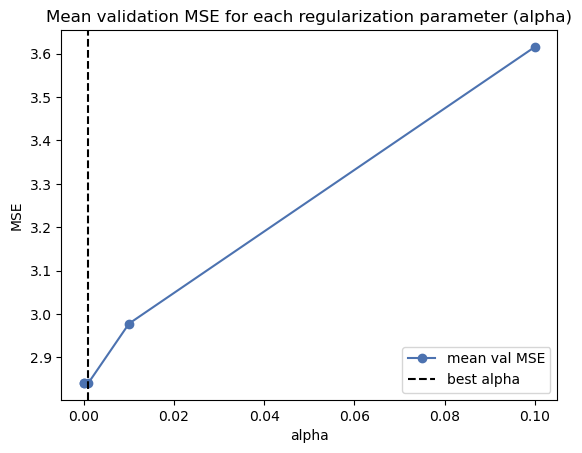

In [120]:
plt.plot(lcv.alphas_, lassoCV_val_mses_mean, marker='o', label='mean val MSE')
plt.axvline(best_alpha, color = 'black', linestyle='--', label = 'best alpha')
plt.title('Mean validation MSE for each regularization parameter (alpha)')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.legend()

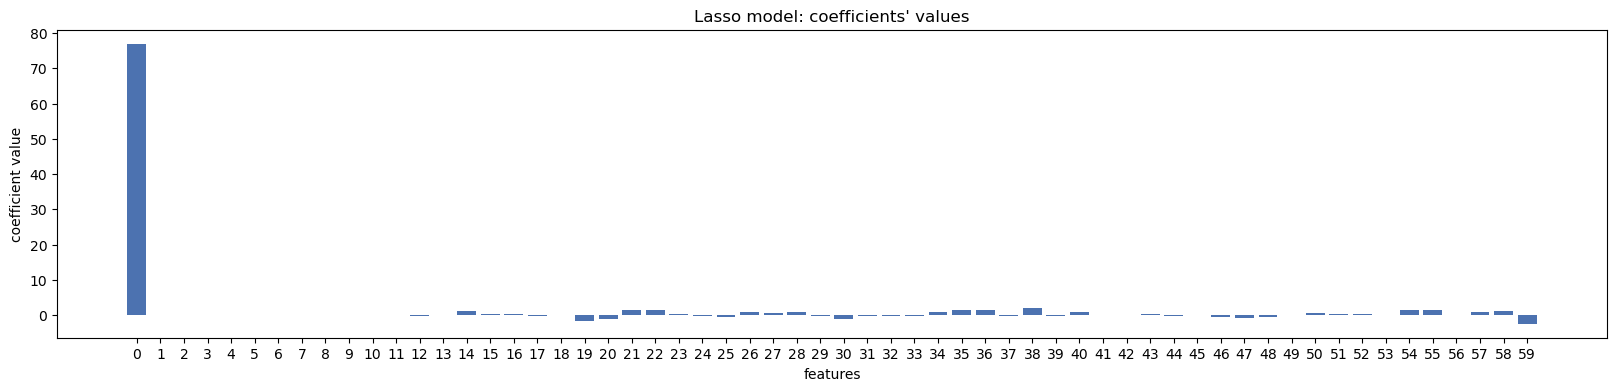

In [121]:
# plt.figure(figsize=(20,4))
# plt.bar(range(0,len(X_cols)), lcv.coef_)
# plt.xticks(range(0,len(X_cols)+1))
# plt.xlabel("feature index")
# plt.ylabel("coefficient value")
# plt.title("Lasso model: coefficients' values")
# plt.show()

plt.figure(figsize=(20,4))
plt.bar(range(0,len(X_cols)+1), np.append(lcv.intercept_,lcv.coef_))
plt.xticks(range(0,len(X_cols)+1))
plt.xlabel("features")
plt.ylabel("coefficient value")
plt.title("Lasso model: coefficients' values")
plt.show()

In [122]:
col_selected = {}
for i, coef in enumerate(lcv.coef_):
    if np.abs(coef) > 0.5:
        col_selected[(X_cols[i])] = coef
print(f"{len(col_selected)} selected features through LassoCV")
pd.DataFrame(col_selected.values(), index=col_selected.keys(), columns=["lasso_cv_coefs"])

21 selected features through LassoCV


lasso_cv_coefs
standardscaler__value_eur                      1.208914
standardscaler__pace                          -1.746826
standardscaler__shooting                      -1.008906
standardscaler__passing                        1.543568
standardscaler__dribbling                      1.449046
standardscaler__attacking_finishing            0.789514
standardscaler__attacking_short_passing        0.794107
standardscaler__skill_dribbling               -1.185453
standardscaler__skill_ball_control             0.931550
standardscaler__movement_acceleration          1.491596
standardscaler__movement_sprint_speed          1.559752
standardscaler__movement_reactions             1.879876
standardscaler__power_shot_power               0.799661
standardscaler__mentality_interceptions       -0.568088
standardscaler__mentality_positioning         -0.820190
standardscaler__mentality_vision              -0.629433
standardscaler__goalkeeping_diving             1.496370
standardscaler__goalkeeping_handling           1.429923
standardscaler__goalkeeping_positioning        0.874312
standardscaler__goalkeeping_reflexes           1.124141
standardscaler__goalkeeping_speed             -2.458297

In [123]:
temp = ["short_name", "country_3d", "overall"]
col_final = temp+list(col_selected.keys())

df_final = np.hstack([df[temp],X[col_selected.keys()]])
df_final = pd.DataFrame(df_final, columns=col_final)
df_final.shape
df_final[df_final.country_3d == "EGY"]

short_name country_3d overall standardscaler__value_eur  \
696   M. Salah        EGY      89                  4.316944   
697  M. Elneny        EGY      77                 -0.353201   

    standardscaler__pace standardscaler__shooting standardscaler__passing  \
696             1.645897                 1.790223                1.457558   
697            -1.464431                 0.101273                0.569728   

    standardscaler__dribbling standardscaler__attacking_finishing  \
696                  2.098522                            1.592534   
697                  -0.24386                            0.041838   

    standardscaler__attacking_short_passing  ...  \
696                                0.961708  ...   
697                                0.624568  ...   

    standardscaler__movement_reactions standardscaler__power_shot_power  \
696                           2.639887                          1.06428   
697                          -0.090178                         0.737706   

    standardscaler__mentality_interceptions  \
696                               -0.031233   
697                                0.856982   

    standardscaler__mentality_positioning standardscaler__mentality_vision  \
696                              1.361262                         1.265334   
697                              0.099893                         0.192674   

    standardscaler__goalkeeping_diving standardscaler__goalkeeping_handling  \
696                            -0.1956                            -0.190768   
697                          -0.518905                             -0.14246   

    standardscaler__goalkeeping_positioning  \
696                               -0.331105   
697                                -0.28458   

    standardscaler__goalkeeping_reflexes standardscaler__goalkeeping_speed  
696                            -0.199944                         -0.354026  
697                            -0.560206                         -0.354026  

[2 rows x 24 columns]

In [124]:
sns.set_palette("deep")

In [125]:
top_countries = [
    # Winners
    "BRA", "GER", "ITA", "ARG"
    ,"FRA", "URU", "ENG", "ESP"
    ,"CRO"
    ]

In [ ]:
#  avg selected categories (attacking, skill, movement, mentality, goalkeeping) to further reduce features
cols_to_avg = ["attacking", "skill", "movement", "mentality", "goalkeeping"]
for col in cols_to_avg:
    to_drop = list(df_final.columns.str.contains(col)*df_final.columns)
    while("" in to_drop):
        to_drop.remove("")
    temp = df_final.filter(like=col)
    df_final = df_final.drop(to_drop, axis=1)
    df_final[col] = temp.mean(axis=1)


In [151]:
# Export database grouped by country to merge with matches
df_final_country = df_final[df_final.columns.drop(["short_name", "overall"])].groupby(by=["country_3d"]).mean()
df_final_country = df_final_country[df_final_country.index != "-----"]
df_final_country.to_csv(path + 'players/players_22_cleaned.csv')

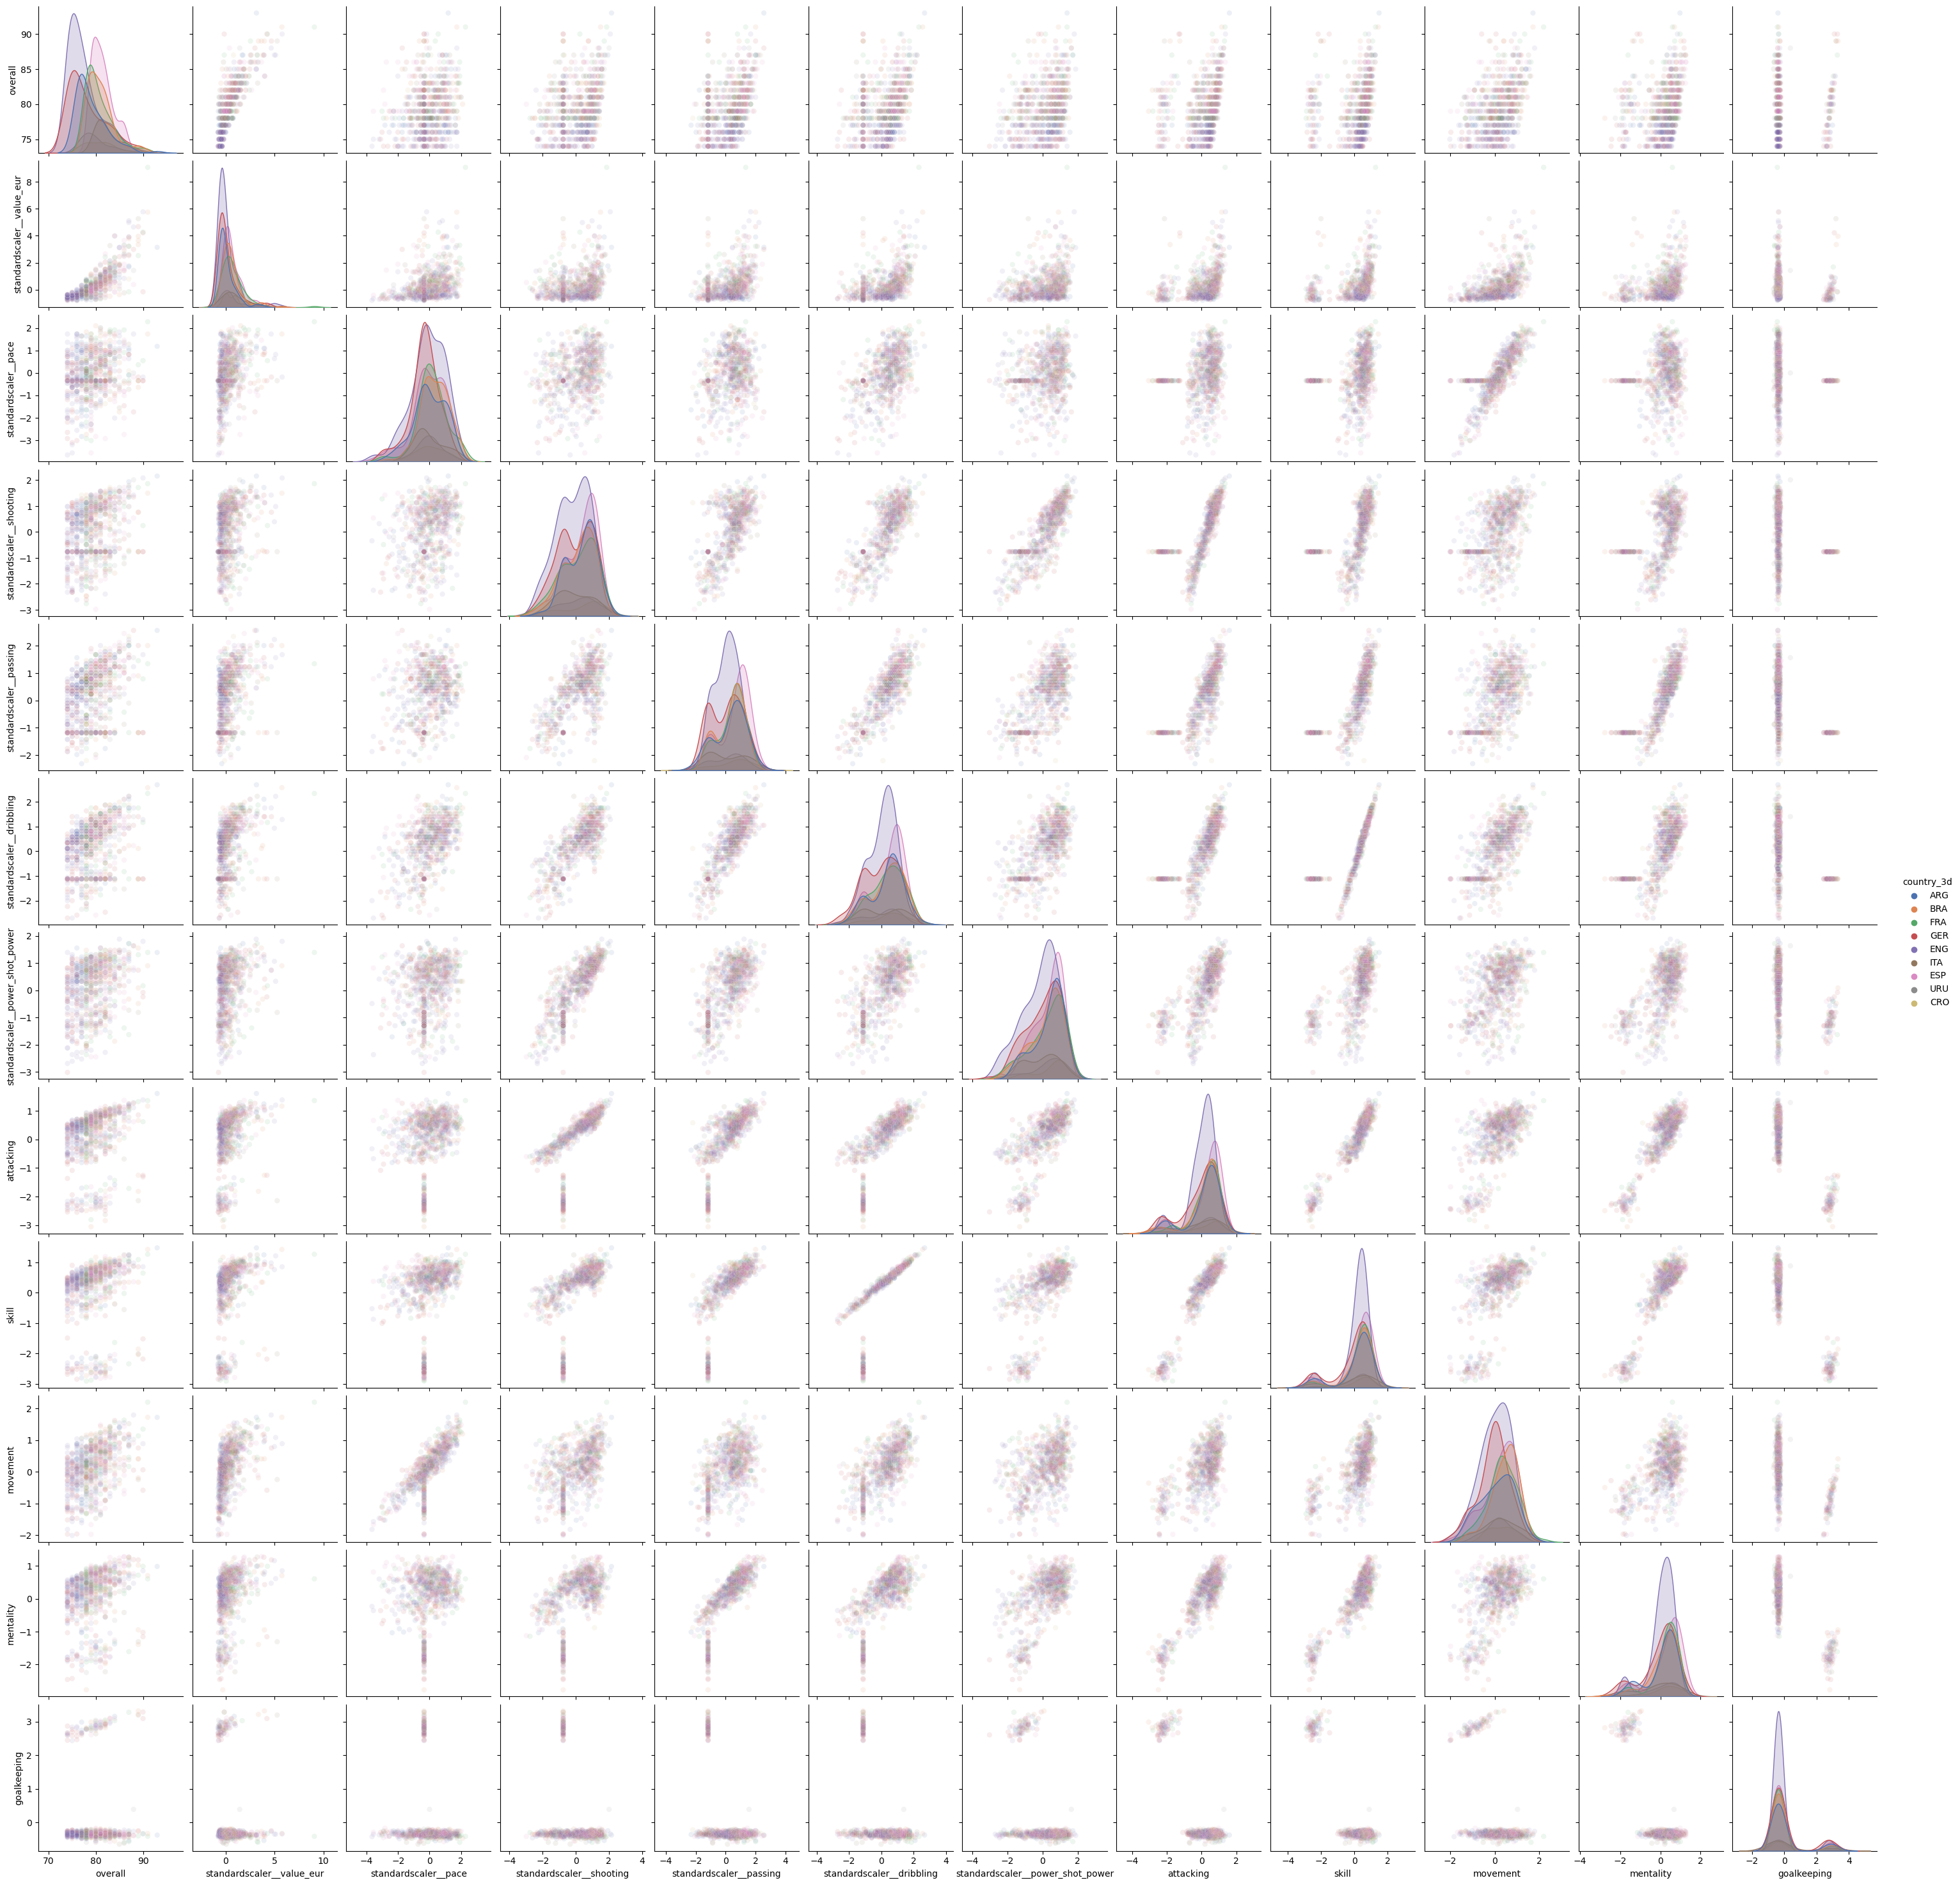

In [126]:
# After, pairplot only with most relevant coefs
df_winners = df_final[df_final["country_3d"].isin(top_countries)]
sns.pairplot(df_winners
    ,hue="country_3d"
    ,kind='scatter'
    ,plot_kws={'alpha':0.1})
plt.show()

## Visualizations for selected countries (previous winners) 

### Players Overall Rating

Text(0.5, 1.0, "FIFA22 Players' Overall Rating Distribution")

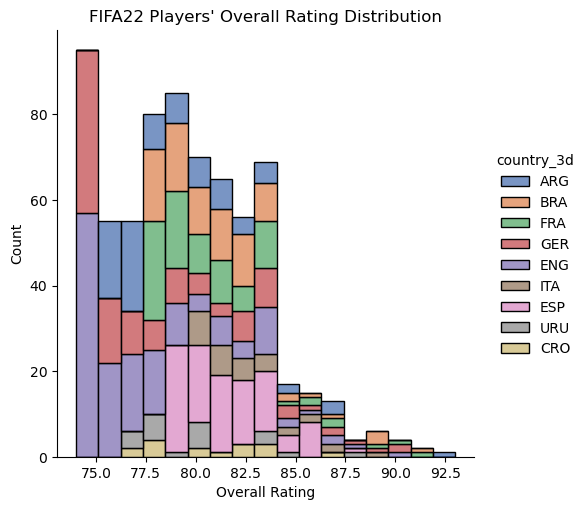

In [127]:
sns.displot(df_winners, x="overall", hue="country_3d", multiple="stack")
plt.xlabel("Overall Rating")
plt.title("FIFA22 Players' Overall Rating Distribution")

Text(0.5, 1.0, "FIFA22 Players' Overall Rating Distribution")

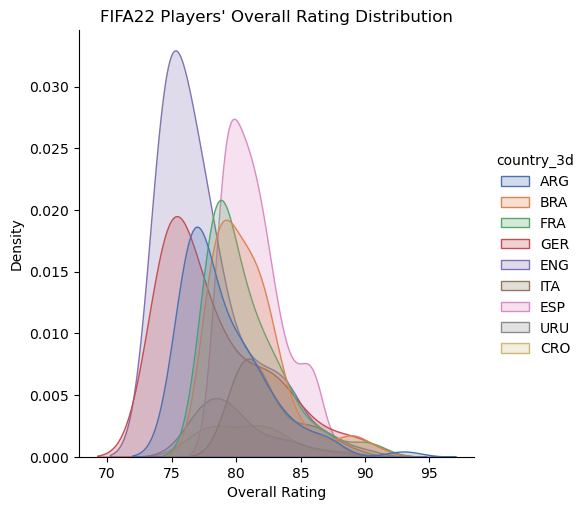

In [128]:
sns.displot(df_winners, x="overall", hue="country_3d", kind="kde", fill=True)
plt.xlabel("Overall Rating")
plt.title("FIFA22 Players' Overall Rating Distribution")

Text(0.5, 1.0, "FIFA22 Players' Overall Rating")

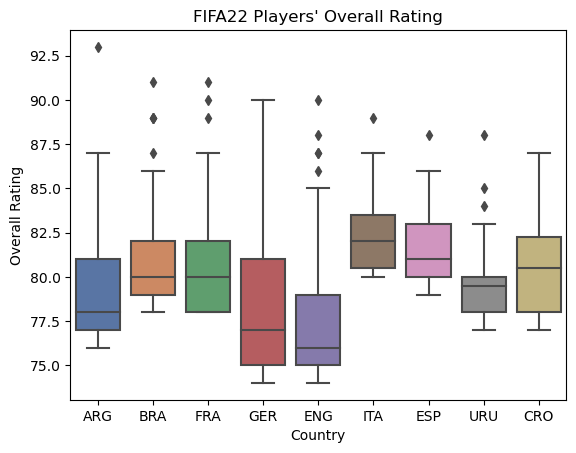

In [129]:
sns.boxplot(data=df_winners, y="overall", x="country_3d")
plt.xlabel("Country")
plt.ylabel("Overall Rating")
plt.title("FIFA22 Players' Overall Rating")

### Overall rating vs players' value (EUR)

Text(0.5, 1.0, "Players' standardized monetary value")

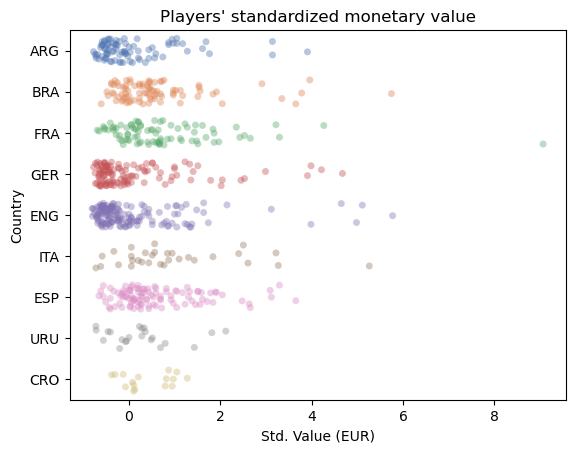

In [130]:
sns.stripplot(data=df_winners, y="country_3d", x="standardscaler__value_eur", alpha = 0.4, jitter=0.3, size=5, marker="o")
plt.xlabel("Std. Value (EUR)")
plt.ylabel("Country")
plt.title("Players' standardized monetary value")

In [131]:
# Additional visualization for the Matches dataset
matches = pd.read_csv(path + 'Fifa_world_cup/WorldCupMatches.csv')

In [132]:
matches

Year              Datetime    Stage         Stadium         City  \
0     1930.0  13 Jul 1930 - 15:00   Group 1         Pocitos  Montevideo    
1     1930.0  13 Jul 1930 - 15:00   Group 4  Parque Central  Montevideo    
2     1930.0  14 Jul 1930 - 12:45   Group 2  Parque Central  Montevideo    
3     1930.0  14 Jul 1930 - 14:50   Group 3         Pocitos  Montevideo    
4     1930.0  15 Jul 1930 - 16:00   Group 1  Parque Central  Montevideo    
...      ...                   ...      ...             ...          ...   
4567     NaN                   NaN      NaN             NaN          NaN   
4568     NaN                   NaN      NaN             NaN          NaN   
4569     NaN                   NaN      NaN             NaN          NaN   
4570     NaN                   NaN      NaN             NaN          NaN   
4571     NaN                   NaN      NaN             NaN          NaN   

     Home Team Name  Home Team Goals  Away Team Goals Away Team Name  \
0            France              4.0              1.0         Mexico   
1               USA              3.0              0.0        Belgium   
2        Yugoslavia              2.0              1.0         Brazil   
3           Romania              3.0              1.0           Peru   
4         Argentina              1.0              0.0         France   
...             ...              ...              ...            ...   
4567            NaN              NaN              NaN            NaN   
4568            NaN              NaN              NaN            NaN   
4569            NaN              NaN              NaN            NaN   
4570            NaN              NaN              NaN            NaN   
4571            NaN              NaN              NaN            NaN   

     Win conditions  Attendance  Half-time Home Goals  Half-time Away Goals  \
0                        4444.0                   3.0                   0.0   
1                       18346.0                   2.0                   0.0   
2                       24059.0                   2.0                   0.0   
3                        2549.0                   1.0                   0.0   
4                       23409.0                   0.0                   0.0   
...             ...         ...                   ...                   ...   
4567            NaN         NaN                   NaN                   NaN   
4568            NaN         NaN                   NaN                   NaN   
4569            NaN         NaN                   NaN                   NaN   
4570            NaN         NaN                   NaN                   NaN   
4571            NaN         NaN                   NaN                   NaN   

                     Referee               Assistant 1  \
0     LOMBARDI Domingo (URU)     CRISTOPHE Henry (BEL)   
1          MACIAS Jose (ARG)  MATEUCCI Francisco (URU)   
2        TEJADA Anibal (URU)   VALLARINO Ricardo (URU)   
3      WARNKEN Alberto (CHI)       LANGENUS Jean (BEL)   
4        REGO Gilberto (BRA)      SAUCEDO Ulises (BOL)   
...                      ...                       ...   
4567                     NaN                       NaN   
4568                     NaN                       NaN   
4569                     NaN                       NaN   
4570                     NaN                       NaN   
4571                     NaN                       NaN   

                     Assistant 2  RoundID  MatchID Home Team Initials  \
0            REGO Gilberto (BRA)    201.0   1096.0                FRA   
1          WARNKEN Alberto (CHI)    201.0   1090.0                USA   
2            BALWAY Thomas (FRA)    201.0   1093.0                YUG   
3       MATEUCCI Francisco (URU)    201.0   1098.0                ROU   
4     RADULESCU Constantin (ROU)    201.0   1085.0                ARG   
...                          ...      ...      ...                ...   
4567                         NaN      NaN      NaN                NaN   


Text(0.5, 1.0, "Total Goals' Distribution (Home Team)")

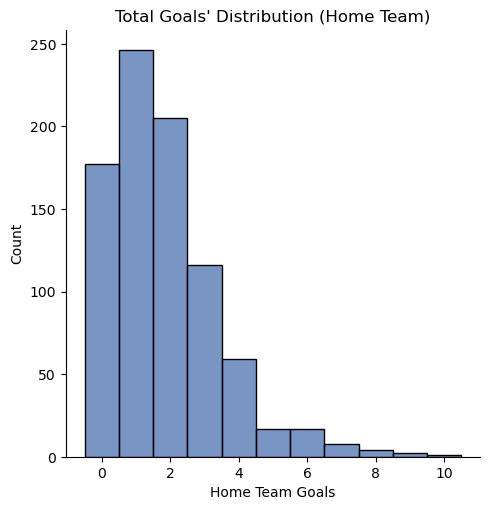

In [133]:
sns.displot(data=matches, x="Home Team Goals", discrete=True)
plt.title("Total Goals' Distribution (Home Team)")

Text(0.5, 1.0, "Total Goals' Distribution (Away Team)")

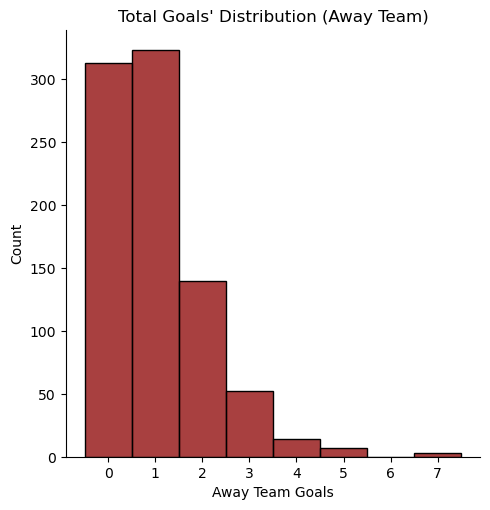

In [134]:
sns.displot(data=matches, x="Away Team Goals" ,discrete=True, color="darkred")
plt.title("Total Goals' Distribution (Away Team)")

In [135]:
col_home = ["Home Team Initials","Home Team Goals", "Stage", "Win conditions", "Away Team Initials"]
matches_home = matches[col_home].dropna()
matches_home["team"] = "Home"
matches_home.rename({"Home Team Initials":"country_3d","Home Team Goals":"goals", "Stage":"stage", "Win conditions": "win_conditions",  "Away Team Initials":"opponent_3d"}
    ,axis=1
    ,inplace=True)

col_away = ["Away Team Initials","Away Team Goals", "Stage", "Win conditions", "Home Team Initials"]
matches_away = matches[col_away].dropna()
matches_away["team"] = "Away"
matches_away.rename({"Away Team Initials":"country_3d","Away Team Goals":"goals", "Stage":"stage", "Win conditions": "win_conditions",  "Home Team Initials":"opponent_3d"}
    ,axis=1
    ,inplace=True)

In [136]:
matches_home

country_3d  goals                     stage  \
0          FRA    4.0                   Group 1   
1          USA    3.0                   Group 4   
2          YUG    2.0                   Group 2   
3          ROU    3.0                   Group 3   
4          ARG    1.0                   Group 1   
..         ...    ...                       ...   
847        NED    0.0            Quarter-finals   
848        BRA    1.0               Semi-finals   
849        NED    0.0               Semi-finals   
850        BRA    0.0  Play-off for third place   
851        GER    1.0                     Final   

                            win_conditions opponent_3d  team  
0                                                  MEX  Home  
1                                                  BEL  Home  
2                                                  BRA  Home  
3                                                  PER  Home  
4                                                  FRA  Home  
..                                     ...         ...   ...  
847  Netherlands win on penalties (4 - 3)          CRC  Home  
848                                                GER  Home  
849    Argentina win on penalties (2 - 4)          ARG  Home  
850                                                NED  Home  
851          Germany win after extra time          ARG  Home  

[852 rows x 6 columns]

In [137]:
matches_long=pd.concat([matches_home, matches_away]).reset_index()

In [138]:
temp = ['country_3d','team', 'goals', 'stage', 'win_conditions',
       'opponent_3d']
matches_long = matches_long[temp]
matches_long

country_3d  team  goals                     stage  \
0           FRA  Home    4.0                   Group 1   
1           USA  Home    3.0                   Group 4   
2           YUG  Home    2.0                   Group 2   
3           ROU  Home    3.0                   Group 3   
4           ARG  Home    1.0                   Group 1   
...         ...   ...    ...                       ...   
1699        CRC  Away    0.0            Quarter-finals   
1700        GER  Away    7.0               Semi-finals   
1701        ARG  Away    0.0               Semi-finals   
1702        NED  Away    3.0  Play-off for third place   
1703        ARG  Away    0.0                     Final   

                             win_conditions opponent_3d  
0                                                   MEX  
1                                                   BEL  
2                                                   BRA  
3                                                   PER  
4                                                   FRA  
...                                     ...         ...  
1699  Netherlands win on penalties (4 - 3)          NED  
1700                                                BRA  
1701    Argentina win on penalties (2 - 4)          NED  
1702                                                BRA  
1703          Germany win after extra time          GER  

[1704 rows x 6 columns]

Text(0.5, 1.0, "Total Goals' Distribution")

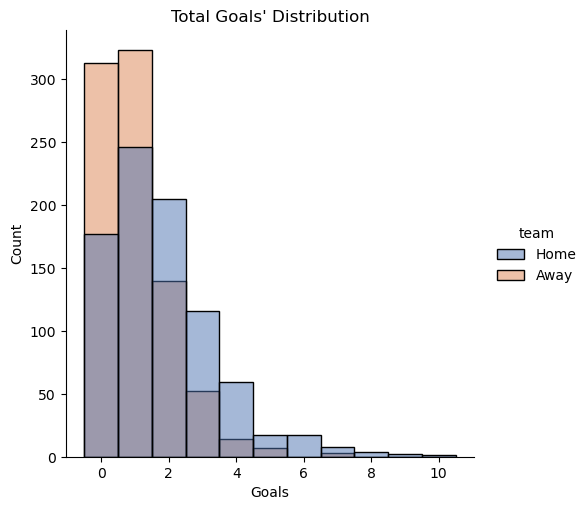

In [139]:
sns.displot(data=matches_long, x="goals", hue="team",discrete=True)
plt.xlabel("Goals")
plt.title("Total Goals' Distribution")